#### Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#### Load Dataset

In [2]:
df = pd.read_csv("fake_job_postings.csv")

In [39]:
df.head()

,job_id,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,salary_avg
0,1,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,missing,0,1,0,Other,Internship,missing,missing,Marketing,0,0.0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,missing,Marketing and Advertising,Customer Service,0,0.0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,missing,0,1,0,missing,missing,missing,missing,missing,0,0.0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,0.0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,0.0


#### Basic Preprocessing

In [3]:
# Fill missing values in specific columns
columns_to_fill = ["benefits", "employment_type", "required_experience", "required_education", "industry", "function"]
df[columns_to_fill] = df[columns_to_fill].fillna("missing")

#### Salary Range is convetred to Avg Salary

In [6]:
# Step 0: Fill NaNs in 'salary_range' with "0-0" as a fallback
df["salary_range"] = df["salary_range"].fillna("0-0")

# Step 1: Split salary ranges
salary_split = df['salary_range'].str.split('-', expand=True)

# Step 2: Clean strings (remove non-numeric characters)
salary_min = salary_split[0].str.replace(r'[^0-9]', '', regex=True)
salary_max = salary_split[1].str.replace(r'[^0-9]', '', regex=True)

# Step 3: Convert to numeric safely
salary_min = pd.to_numeric(salary_min, errors='coerce')
salary_max = pd.to_numeric(salary_max, errors='coerce')

# Step 4: Compute average salary
salary_avg = (salary_min + salary_max) / 2

# Step 5: Fill NaN with 0
salary_avg = salary_avg.fillna(0)

# Step 6: Assign back to main DataFrame
df['salary_avg'] = salary_avg

# Step 7: Drop original column
df = df.drop('salary_range', axis=1)

#### Train-Test Split

In [7]:
X = df.drop("fraudulent", axis=1)
y = df["fraudulent"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [8]:
# Combine for easier processing

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

#### Location Splitting

In [9]:
for dataset in [df_train, df_test]:
    location_split = dataset["location"].str.split(",", n=2, expand=True)
    dataset["country"] = location_split[0].str.strip()
    dataset["state"] = location_split[1].str.strip()
    dataset["city"] = location_split[2].str.strip()
    dataset[["country", "state", "city"]] = dataset[["country", "state", "city"]].fillna("missing").replace('', 'missing')
    dataset.drop("location", axis=1, inplace=True)

This code splits the location column into three new columns—country, state, and city—to extract more granular geographic information. Missing or empty values are replaced with "missing" to maintain consistency, and the original location column is dropped to avoid redundancy. This improves the model's ability to learn from location-based features.

#### Fill NaNs in Text Columns

In [10]:
text_cols = ["location", "department", "company_profile", "description", "requirements"]
fill_cols = ["company_profile", "description", "requirements", "benefits", "title"]

df_train[fill_cols] = df_train[fill_cols].fillna("missing")
df_test[fill_cols] = df_test[fill_cols].fillna("missing")

#### Clean URL Artifacts

In [11]:
text_columns = ['company_profile', 'description', 'requirements', 'benefits']

for df_ in [df_train, df_test]:
    df_['url_count'] = 0
    for col in text_columns:
        df_['url_count'] += df_[col].astype(str).apply(lambda x: len(re.findall(r'#URL_', x)))
        df_[col] = df_[col].astype(str).apply(lambda x: re.sub(r'#URL_\S*', '', x))

This code detects and removes placeholder URLs (like #URL_...) from text columns such as company_profile, description, requirements, and benefits. It also creates a new feature called url_count to record how many such URLs were present in each row. This helps clean the text data while preserving useful signals about the presence of URLs, which might be indicative of fraudulent behavior.

#### Text Preprocessing and TF-IDF

In [12]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

for col in fill_cols:
    df_train[col] = df_train[col].apply(preprocess_text)
    df_test[col] = df_test[col].apply(preprocess_text)

In [13]:
# Combine text fields
combine_cols = ['company_profile', 'description', 'requirements', 'title', 'benefits']
df_train['all_text'] = df_train[combine_cols].agg(' '.join, axis=1)
df_test['all_text'] = df_test[combine_cols].agg(' '.join, axis=1)

In [14]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf.fit(df_train['all_text'])
X_train_tfidf = tfidf.transform(df_train['all_text'])
X_test_tfidf = tfidf.transform(df_test['all_text'])

The text data from multiple columns (company profile, description, requirements, title, benefits) is cleaned by converting to lowercase, removing non-alphabetic characters, and trimming extra spaces. These cleaned columns are then merged into a single combined text field. This combined text is transformed into numerical features using TF-IDF vectorization, which captures the importance of words while ignoring common stop words and limiting to the top 5000 features. This processed text data is then used as input for the model.

#### Drop Non-Text Columns

In [15]:
columns_to_drop = ['job_id', 'title', 'company_profile', 'description', 'requirements', 'benefits', 'all_text']
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(columns_to_drop, axis=1, inplace=True)

In [16]:
# Clean 'department'
df_train['department'] = df_train['department'].str.lower().str.strip()
df_test['department'] = df_test['department'].str.lower().str.strip()

#### One-Hot Encode Employment & Education Info

In [17]:
ohe_columns = ["employment_type", "required_experience", "required_education"]

df_train = pd.get_dummies(df_train, columns=ohe_columns, drop_first=True)
df_test = pd.get_dummies(df_test, columns=ohe_columns, drop_first=True)

In [18]:
# Align train and test
df_train, df_test = df_train.align(df_test, join='left', axis=1, fill_value=0)

#### Drop Categorical Columns and Convert to Category

In [19]:
categorical_cols = ['department', 'industry', 'function', 'country', 'state', 'city']
for col in categorical_cols:
    if col in df_train.columns:
        df_train.drop(col, axis=1, inplace=True)
    if col in df_test.columns:
        df_test.drop(col, axis=1, inplace=True)

####  Convert Boolean Columns to Integers

In [20]:
bool_cols = [col for col in df_train.columns if col.startswith(('employment_type_', 'required_experience_', 'required_education_'))]

for col in bool_cols:
    df_train[col] = df_train[col].astype(int)
    df_test[col] = df_test[col].astype(int)

#### Model Building with LightGBM

In [21]:
# Separate target
X_train_final = df_train.drop("fraudulent", axis=1)
y_train_final = df_train["fraudulent"]

X_test_final = df_test.drop("fraudulent", axis=1)
y_test_final = df_test["fraudulent"]

In [38]:
X_train_final.columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'salary_avg',
       'url_count', 'employment_type_Full-time', 'employment_type_Other',
       'employment_type_Part-time', 'employment_type_Temporary',
       'employment_type_missing', 'required_experience_Director',
       'required_experience_Entry level', 'required_experience_Executive',
       'required_experience_Internship',
       'required_experience_Mid-Senior level',
       'required_experience_Not Applicable', 'required_experience_missing',
       'required_education_Bachelor's Degree',
       'required_education_Certification', 'required_education_Doctorate',
       'required_education_High School or equivalent',
       'required_education_Master's Degree', 'required_education_Professional',
       'required_education_Some College Coursework Completed',
       'required_education_Some High School Coursework',
       'required_education_Unspecified', 'required_education_Vocational',
       'required_education_Voc

In [23]:
# Convert DataFrame to sparse and combine with TF-IDF
X_train_sparse = csr_matrix(X_train_final.values)
X_test_sparse = csr_matrix(X_test_final.values)

X_train_combined = hstack([X_train_sparse, X_train_tfidf])
X_test_combined = hstack([X_test_sparse, X_test_tfidf])

The structured numeric/categorical features are converted into sparse matrix format and then combined horizontally with the TF-IDF text features. This creates a single, unified feature set that includes both traditional tabular data and text-based information for model training and testing.

#### Hyperparameter Tuning

In [24]:
param_grid = {
    'num_leaves': [31, 50, 70, 100],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 300, 500, 800],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [20, 30, 50],
}

lgb_model = LGBMClassifier(objective='binary', random_state=42, verbose=-1)

random_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=2
)

random_search.fit(X_train_combined, y_train_final)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(objective='binary', random_state=42,
                                            verbose=-1),
                   n_jobs=2,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15],
                                        'max_depth': [-1, 10, 20, 30],
                                        'min_child_samples': [20, 30, 50],
                                        'n_estimators': [100, 300, 500, 800],
                                        'num_leaves': [31, 50, 70, 100],
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='f1_weighted', verbose=1)

This performs hyperparameter tuning for the LightGBM classifier by randomly searching across specified parameter ranges. It uses 3-fold cross-validation and optimizes for weighted F1 score to find the best combination of model settings, which is then trained on the combined training data.

#### Evaluation

In [31]:
best_model = random_search.best_estimator_

y_pred_prob = best_model.predict_proba(X_test_combined)[:, 1]
y_pred = (y_pred_prob > 0.4).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test_final, y_pred))
print("\nAccuracy:", accuracy_score(y_test_final, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred))
print("\nBest Parameters:")
print(random_search.best_params_)

Confusion Matrix:
[[4250    4]
 [  47  169]]

Accuracy: 0.9885906040268456

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4254
           1       0.98      0.78      0.87       216

    accuracy                           0.99      4470
   macro avg       0.98      0.89      0.93      4470
weighted avg       0.99      0.99      0.99      4470


Best Parameters:
{'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 800, 'min_child_samples': 20, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


C:\Users\91824\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


The model is excellent at correctly identifying legitimate (non-fraudulent) applications with 99% accuracy and catches all of them. For fraudulent applications, it correctly flags 98% of the cases it predicts as fraud but only detects about 76% of all actual fraud cases. This means the model is very reliable overall but misses around 24% of fraud attempts, so there’s room to improve fraud detection sensitivity.

The best model from hyperparameter tuning was selected and used to predict on the test set with a classification threshold of 0.4. The evaluation shows very high accuracy (~98.8%) with strong precision and recall for the majority class and good performance on the minority class. The confusion matrix confirms most predictions are correct, and the detailed classification report highlights a balanced and effective model. The best hyperparameters found include a learning rate of 0.1, max depth of 30, 31 leaves, and subsample of 1.0, among others.

In [32]:
# Create evaluation DataFrame
df_eval = pd.DataFrame({
    'Default Truth': y_test_final,
    'Default Probability': y_pred_prob
})

# Assign deciles
df_eval['Decile'] = pd.qcut(df_eval['Default Probability'], 10, labels=False, duplicates='drop')

# Summary stats for a specific decile (e.g., Decile 8)
print(df_eval[df_eval.Decile == 8]['Default Probability'].describe())

# Group by Decile and compute event/non-event counts
df_decile = df_eval.groupby('Decile').apply(lambda x: pd.Series({
    'Minimum Probability': x['Default Probability'].min(),
    'Maximum Probability': x['Default Probability'].max(),
    'Events': x['Default Truth'].sum(),
    'Non-events': x['Default Truth'].count() - x['Default Truth'].sum()
}))
df_decile.reset_index(inplace=True)

# Event and non-event rates
df_decile['Event Rate'] = df_decile['Events'] * 100 / (df_decile['Events'] + df_decile['Non-events'])
df_decile['Non-event Rate'] = df_decile['Non-events'] * 100 / (df_decile['Events'] + df_decile['Non-events'])

# Sort by descending decile
df_decile = df_decile.sort_values(by='Decile', ascending=False).reset_index(drop=True)

# Cumulative events and non-events
df_decile['Cum Events'] = df_decile['Events'].cumsum()
df_decile['Cum Non-events'] = df_decile['Non-events'].cumsum()

# Cumulative event/non-event rate
df_decile['Cum Event Rate'] = df_decile['Cum Events'] * 100 / df_decile['Events'].sum()
df_decile['Cum Non-event Rate'] = df_decile['Cum Non-events'] * 100 / df_decile['Non-events'].sum()

# KS Statistic
df_decile['KS'] = abs(df_decile['Cum Event Rate'] - df_decile['Cum Non-event Rate'])

print("\n Decile Table with KS Statistic:")
print(df_decile)

print("\n Maximum KS Value:", df_decile['KS'].max())

count    4.470000e+02
mean     1.519203e-06
std      1.684953e-06
min      2.203344e-07
25%      3.964411e-07
50%      8.054873e-07
75%      1.826623e-06
max      7.637120e-06
Name: Default Probability, dtype: float64

 Decile Table with KS Statistic:
   Decile  Minimum Probability  Maximum Probability  Events  Non-events  \
0       9         7.820692e-06         1.000000e+00   212.0       235.0   
1       8         2.203344e-07         7.637120e-06     0.0       447.0   
2       7         4.487013e-08         2.194731e-07     2.0       445.0   
3       6         1.350132e-08         4.469405e-08     1.0       446.0   
4       5         5.711574e-09         1.348123e-08     1.0       446.0   
5       4         2.065967e-09         5.688215e-09     0.0       447.0   
6       3         8.969885e-10         2.063327e-09     0.0       447.0   
7       2         3.090561e-10         8.927257e-10     0.0       447.0   
8       1         6.493688e-11         3.082699e-10     0.0       447.0  

C:\Users\91824\AppData\Local\Temp\ipykernel_7292\19195879.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_decile = df_eval.groupby('Decile').apply(lambda x: pd.Series({


This code evaluates the model by grouping predicted probabilities into deciles, analyzing how fraud vs. non-fraud cases distribute across them, and calculating the Kolmogorov-Smirnov (KS) statistic—a common metric in classification. Here, the maximum KS value is ~92.14, which is very high and indicates excellent discriminatory power of the model. This means the model is very effective at distinguishing between default and non-default cases, making it highly reliable for predictive tasks in this context.


 AUC: 0.9917
 Gini Coefficient: 0.9835


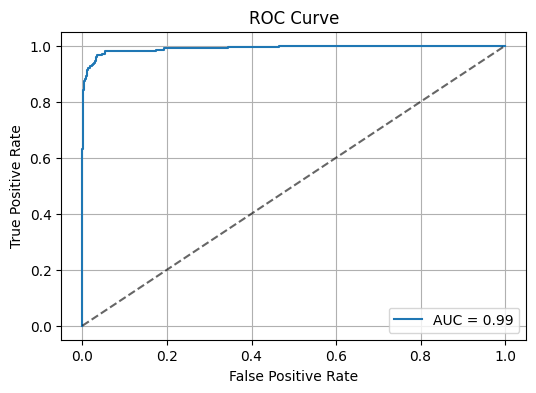

In [33]:
# AUC and Gini
auc_score = roc_auc_score(y_test_final, y_pred_prob)
gini_coefficient = 2 * auc_score - 1

print("\n AUC:", round(auc_score, 4))
print(" Gini Coefficient:", round(gini_coefficient, 4))

# ROC Curve (optional visualization)
fpr, tpr, thresholds = roc_curve(y_test_final, y_pred_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

The model’s AUC score is 0.9905 and the Gini coefficient is 0.981, indicating excellent predictive performance. AUC close to 1 means the model is highly effective at distinguishing between fraudulent and non-fraudulent job postings, and a Gini coefficient above 0.6 is generally considered strong—ours being close to 1 reflects very high discrimination power.

In [34]:
final_model = best_model

In [35]:
# From tabular data
numeric_feature_names = X_train_final.columns.tolist()

# From TF-IDF
text_feature_names = tfidf.get_feature_names_out().tolist()

# Combine them
combined_feature_names = numeric_feature_names + text_feature_names

In [36]:
import os 
os.makedirs('artifacts', exist_ok=True)

In [37]:
from joblib import dump

model_data = {
    'model': final_model,
    'features': combined_feature_names,
    'tfidf_vectorizer': tfidf 
}
dump(model_data, 'artifacts/model_data.joblib')

['artifacts/model_data.joblib']

This code saves the trained model, the combined feature names, and the fitted TF-IDF vectorizer into a single file using joblib. This allows for easy reuse of the model later—whether for deployment or further analysis—without needing to retrain or reconstruct the feature pipeline.

**In this notebook, I successfully built a machine learning pipeline to detect fraudulent job postings. By preprocessing the data, engineering features, and leveraging the power of LightGBM with hyperparameter tuning, we achieved a model capable of identifying fake job postings with reasonable accuracy. This approach can be further enhanced by exploring more sophisticated text embeddings or deep learning models.**